In [1]:
import tensorflow as tf

In [40]:
from tensorflow.keras.utils import image_dataset_from_directory
import os.path
from pathlib import Path
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

## DATA EXPLORATION

### Load data

In [3]:
!pwd

/Users/thomas/code/wroby/foodE/notebooks


In [4]:
PATH = "../raw_data/food-101/images"

### Train/test split

In [5]:
train = image_dataset_from_directory(PATH,label_mode="categorical", color_mode="rgb", 
                                  validation_split=0.2, subset="training",
                                  image_size=(512,512), interpolation="nearest",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.


In [63]:
validation = image_dataset_from_directory(PATH,label_mode="categorical", color_mode="rgb", 
                                  validation_split=0.2, subset="validation",
                                  image_size=(512,512), interpolation="nearest",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)

Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [65]:
## Trouver un moyen de split le dataset en train et test
## Créer directement les dossiers train et test semble etre la solution optimal.
## d'autres solutions sur dispo sur StackOverflow mais ne semble pas permettre d'assurer la balance entre les labels.

### Visualise datasets


2023-02-01 15:25:50.975018: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


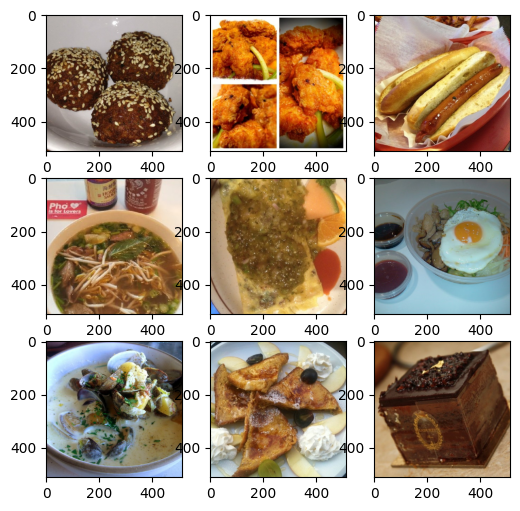

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(6,6))
 
for images, labels in train.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
    for i in range(3):
        ax[1][i].imshow(images[i+3].numpy().astype("uint8"))
    for i in range(3):
        ax[2][i].imshow(images[i+6].numpy().astype("uint8"))
plt.show()

## Preprocessing

In [ ]:
## Definir la function preprocess
def preprocessing(images, labels):
    ## Use the preprocess_input for each specific model
    return tf.keras.applications.mobilenet_v2.preprocess_input(tf.image.convert_image_dtype(images, tf.float32)), labels
    ## will scale input pixels between -1 and 1
    
## Appliquer la function sur le dataset
train = train.map(preprocessing)

## Model training

In [54]:
img_height = 512
img_width = 512


### Define the model

In [55]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet', 
    pooling='avg'
)

In [56]:
base_model.trainable = False

### Add custom layer

In [57]:
model = tf.keras.Sequential([
 ## Data Augmentation layer   
tf.keras.layers.RandomFlip(mode="horizontal", seed=42), 
tf.keras.layers.RandomRotation(factor=0.05, seed=42), 
tf.keras.layers.RandomContrast(factor=0.2, seed=42),
## Base model
base_model,
## FNN
tf.keras.layers.Dense(128,activation='relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(101,kernel_regularizer=regularizers.l2(0.005),activation='softmax')
])

In [58]:
## Build the model for some reason
model.build(input_shape=(None, img_height, img_width, 3))

In [59]:
## Deep Neural Architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (None, 512, 512, 3)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 512, 512, 3)      0         
 tation)                                                         
                                                                 
 random_contrast_6 (RandomCo  (None, 512, 512, 3)      0         
 ntrast)                                                         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_11 (Dense)            (None, 128)               163968    
                                                      

### Compiling

In [60]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

### Fitting

In [61]:
## Early stopping
es = EarlyStopping(monitor="accuracy",
                    patience=2,
                    mode="min",
                    restore_best_weights=True)

In [62]:
history = model.fit(
    train, 
    epochs=2, 
    verbose=1,
    validation_data=test,
    shuffle=True,
    batch_size=32,
    callbacks=[es])      

Epoch 1/2
1185/2525 [=============>................] - ETA: 25:09 - loss: 4.6775 - accuracy: 0.0092

KeyboardInterrupt: 